In [1]:
import pymongo
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# dans le string on peut passer les contraintes sur R et W
conn_str = "mongodb://localhost:27017/"
try:
    mongo_client = pymongo.MongoClient(conn_str, serverSelectionTimeoutMS=5000)
    print("Pymongo : connection OK")
    db = mongo_client.gdelt
    coll = db.evt
except Exception:
    print("Pymongo : unable to connect to the server.")

Pymongo : connection OK


In [3]:
count = coll.estimated_document_count()
print(f"total number of documents in the collection : {count}")

total number of documents in the collection : 39385845


## **Requête 1**

In [4]:
day = datetime.datetime(2021,3,8)
country = "GM"
lang = "eng"
limit_total_events = 10000

start = datetime.datetime.now()

cursor = coll.aggregate([
    {"$match": {"$and": [{"date":day},{"country":country}]}},
    {"$project": {"_id":0,"ID":1, "list_articles":1,"num_mentions":1}},
    {"$unwind": "$list_articles"},
    {"$match": {"list_articles.lang": lang}},
    {"$group": {"_id":[{"event":"$ID"}, {"num_mentions":"$num_mentions"}],"nb_articles":{"$count":{}}}},
    {"$sort": {"nb_articles":-1}}
#     ,{"$limit": limit_total_events}
])

duration1 = datetime.datetime.now() - start
print(f"query processed in {duration1}")

start = datetime.datetime.now()
df_res = pd.DataFrame(list(cursor))

new_col = ["event", "num_mentions"]

for i, col in enumerate(new_col):
    df_res.insert(i+1, col, df_res.loc[:, '_id'].apply(pd.Series)[i])
    df_res.loc[:, col] = df_res.loc[:, col].apply(lambda x : x.get(col))
    
df_res = df_res.drop('_id', axis=1)
    
# df_res.loc[:, "_id"] = df_res.loc[:, "_id"].apply(lambda x : re.search("\d+", str(x)).group(0))

df_res = df_res.set_index("event")
duration2 = datetime.datetime.now() - start

print(f"results gathered in dataframe in {duration2}")

print(f"total time : {duration1 + duration2}")
df_res

query processed in 0:00:08.526169
results gathered in dataframe in 0:00:00.423776
total time : 0:00:08.949945


,num_mentions,nb_articles
event,,
973376328,10,105
973376244,5,103
973376488,10,102
973376489,10,102
973375482,10,100
...,...,...
973341904,3,1
973390731,5,1
973466199,5,1


## **Requête 2**

In [ ]:
country="JA"
granularity="d"
mentions_treshold = 20  # US : 100, autre : 20
limit_events_per_granularity = 15

# VERSION MONGO-PANDAS
start = datetime.datetime.now()
cursor = coll.aggregate([
    {"$match": {"$and": [{"country":country},{"num_mentions":{"$gt":mentions_treshold}}]}}, # AVEC TRESHOLD
    {"$project": {"_id":0,
                  "ID":1,
                  "time":"$date",
                  "num_mentions":1}},
                  # un limit global n'a pas de sens ici car données non triées
])

duration1 = datetime.datetime.now() - start
print(f"query processed in {duration1}")

start = datetime.datetime.now()
df_res = pd.DataFrame(list(cursor))
print(f"number of events returned before post-processing : {len(df_res)}")
if granularity == 'd':
    strf='%Y/%m/%d'
elif granularity == 'm':
    strf='%Y/%m'
else:
    strf='%Y'
df_res["time"] = pd.to_datetime(df_res["time"]).dt.strftime(strf)
df_res = df_res.sort_values(['time','num_mentions'],ascending=[True,False])
df_res = df_res.set_index('time')
df_res = df_res.groupby(df_res.index).head(limit_events_per_granularity)
duration2 = datetime.datetime.now() - start

print(f"results gathered in dataframe in {duration2}")

print(f"total time : {duration1 + duration2}")
df_res

## **Requête 3**

In [21]:
source="lorrain"
granularity="m" #d/m/y",
var="persons" #"theme", "locs", "persons"
limit_total_responses = 500

dico_rq3 = {"$group": {"_id": [{"source":"$list_articles.source"}, 
                               {"$cond": [var=="theme", 
                                          {f"{var}":f"${var}_base"}, 
                                          {f"{var}":f"$list_articles.{var}"}]}, 
                               {"time":{"$cond": [granularity=='d', {"$concat":[{"$toString":{"$year":"$date"}}, 
                                                                                '/', 
                                                                                {"$toString":{"$month":"$date"}},
                                                                                '/', 
                                                                                {"$toString":{"$dayOfMonth":"$date"}}]}, 
                                                  {"$cond": [granularity=='m', 
                                                             {"$concat":[{"$toString":{"$year":"$date"}},    
                                                                         '/', 
                                                                         {"$toString":{"$month":"$date"}}]}, 
                                                             {"$toString":{"$year":"$date"}}]}]}}], 
                       "nb_articles": {"$count":{}}, 
                       "avg_tone": {"$avg":{"$toDouble":"$list_articles.tone"}}}}

start = datetime.datetime.now()

if var=='theme':
    cursor = coll.aggregate([
        {"$match": {"list_articles.source":{"$regex":source}}},
        {"$unwind":"$list_articles"},
        {"$match": {"list_articles.source":{"$regex":source}}},
        dico_rq3,
        {"$sort": {"nb_articles":-1, "time":1}},
        {"$limit": limit_total_responses}
    ])
    
else:
     cursor = coll.aggregate([
        {"$match": {"list_articles.source":{"$regex":source}}},
        {"$unwind":"$list_articles"},
        {"$match": {"list_articles.source":{"$regex":source}}},
        {"$unwind": f"$list_articles.{var}"},
        dico_rq3,
        {"$sort": {"nb_articles":-1, "time":1}},
        {"$limit": limit_total_responses}
    ])
    

# print_find(cursor)

duration1 = datetime.datetime.now() - start
print(f"query processed in {duration1}")

start = datetime.datetime.now()
df_res = pd.DataFrame(list(cursor))


new_col = ["source", var, "time"]
#transforme une colonne pandas composée d'une liste de dictionnaires en plusieurs colonnes
for i, col in enumerate(new_col):
    df_res.insert(i+1, col, df_res.loc[:, '_id'].apply(pd.Series)[i])
    df_res.loc[:, col] = df_res.loc[:, col].apply(lambda x : x.get(col))
    
df_res = df_res.drop('_id', axis=1)
#df_test.loc[:, 'time'] = pd.to_datetime(df_test.loc[:, 'time'], format='%Y/%m').dt.month
duration2 = datetime.datetime.now() - start

print(f"results gathered in dataframe in {duration2}")

print(f"total time : {duration1 + duration2}")
df_res

query processed in 0:04:11.532641
results gathered in dataframe in 0:00:00.253292
total time : 0:04:11.785933


,source,persons,time,nb_articles,avg_tone
0,republicain-lorrain.fr,joe biden,2021/1,131,-2.339645
1,republicain-lorrain.fr,donald trump,2021/1,100,-2.776858
2,republicain-lorrain.fr,joe biden,2021/3,80,-3.093010
3,republicain-lorrain.fr,suu kyi,2021/2,60,-5.917874
4,republicain-lorrain.fr,suu kyi,2021/3,54,-5.954843
...,...,...,...,...,...
495,republicain-lorrain.fr,gerald darmanin,2021/2,4,-2.645664
496,republicain-lorrain.fr,abu bakar bachir,2021/1,4,-7.279693
497,republicain-lorrain.fr,evelyn firtion,2021/4,4,-1.546392
498,republicain-lorrain.fr,thomas piketty,2021/2,4,-5.622848


## **Requête 4**

In [15]:
def bloc_match_1(month_start,next_month_start):
    # util function used in all queries
    dico_bloc_match_1 = {"$and":[
        {"$or":[
            {"$and": [{"act1_country":pays_1}, {"act2_country":pays_2}]},
            {"$and": [{"act1_country":pays_2}, {"act2_country":pays_1}]}]},
        {"$and":[{"date": {"$gte":month_start}},{"date": {"$lt":next_month_start}}]}
        ]}
    return dico_bloc_match_1


def process_all_queries(date_range):
    # processes all queries (tone,articles,events,events_code, localisations, persons, sources) and return a list of dfs (one per month in daterange)
    
    queries_start = datetime.datetime.now()
    
    list_monthly_dfs = [pd.DataFrame() for i in range(len(date_range)-1)]
    for i in range(len(date_range)-1):
        month_start = date_range[i]
        next_month_start = date_range[i+1]

        start = datetime.datetime.now()
        # nb d'events
        nb_events = coll.count_documents(bloc_match_1(month_start,next_month_start))
        # nb d'articles
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$unwind":"$list_articles"},
            {"$count":"nb_articles"}
        ])
        nb_articles = list(cursor)[0]['nb_articles']
        # ton moyen
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$group":{"_id":"_id","avg_evt_tone":{'$avg':"$tone"}}}
        ])
        avg_tone = list(cursor)[0]['avg_evt_tone']
        # regroupement    
        _id = ["nb_events","nb_articles","avg_tone"]
        val = [nb_events,nb_articles,avg_tone]
        df_scalar = pd.DataFrame(zip(_id,val))
        df_scalar = df_scalar.set_axis(["_id","val"],axis=1)
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : scalar queries processed in {duration1}")

        # most common event_codes - exprimé en nombre d'events par type
        start = datetime.datetime.now()
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$group":{"_id":"$theme_base","val":{'$count':{}}}},
            {"$sort": {"val":-1}},
            {"$limit":n_limit}
        ])
        df_res_evt_code = pd.DataFrame(list(cursor))
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : event type query processed in {duration1}")



        # top 3 people - exprimé en nombre d'articles citant chaque personne
        start = datetime.datetime.now()
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$unwind":"$list_articles"},
            {"$unwind":"$list_articles.persons"},
            {"$group": {"_id": "$list_articles.persons","val":{"$count":{}}}},
            {"$sort": {"val":-1}},
            {"$limit":n_limit}
        ])
        df_res_pers = pd.DataFrame(list(cursor))
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : persons query processed in {duration1}")
        
        
        # top 3 organizations
        start = datetime.datetime.now()
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$unwind":"$list_articles"},
            {"$unwind":"$list_articles.org"},
            {"$group": {"_id": "$list_articles.org","val":{"$count":{}}}},
            {"$sort": {"val":-1}},
            {"$limit":n_limit}
        ])
        df_res_orgs = pd.DataFrame(list(cursor))
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : organizations query processed in {duration1}")


        # top 3 locations
        start = datetime.datetime.now()
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$unwind":"$list_articles"},
            {"$unwind":"$list_articles.locs"},
            {"$group": {"_id": "$list_articles.locs","val":{"$count":{}}}},
            {"$sort": {"val":-1}},
            {"$limit": n_limit}
        ])
        df_res_locs = pd.DataFrame(list(cursor))
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : locations query processed in {duration1}")


        # top 3 sources
        start = datetime.datetime.now()
        cursor = coll.aggregate([
            {"$match" : bloc_match_1(month_start,next_month_start)},
            {"$unwind":"$list_articles"},
            {"$group": {"_id": "$list_articles.source","val":{"$count":{}}}},
            {"$sort": {"val":-1}},
            {"$limit":n_limit}
        ])
        df_res_src = pd.DataFrame(list(cursor))
        duration1 = datetime.datetime.now() - start
        print(f"{month_start.strftime('%Y-%m')} : sources query processed in {duration1}")

        # vertical concatenation of all sub_df of the current month
        list_sub_df_per_month = [df_scalar,df_res_evt_code,df_res_pers,df_res_orgs,df_res_locs,df_res_src]
        for df in list_sub_df_per_month:
            list_monthly_dfs[i] = pd.concat([list_monthly_dfs[i],df],axis=0)

        # --Indexation of monthly df
        # index length will be < than (3 + 5 * n_limit) if not enough rows matching some requests
        index = ["nb_events","nb_articles","avg_tone"]
        index.extend([f"event_type_{i}" for i in range(len(df_res_evt_code))])
        index.extend([f"person_{i}" for i in range(len(df_res_pers))])
        index.extend([f"org_{i}" for i in range(len(df_res_orgs))])
        index.extend([f"locs_{i}" for i in range(len(df_res_locs))])
        index.extend([f"source_{i}" for i in range(len(df_res_src))])
        list_monthly_dfs[i] = list_monthly_dfs[i].set_axis(index,axis=0)
        list_monthly_dfs[i]["val"] = list_monthly_dfs[i]["val"].round(1)

    queries_duration = datetime.datetime.now() - queries_start
    print(f"Total query time : {queries_duration}")
    return list_monthly_dfs

def generate_global_df(list_monthly_dfs):
    # gathers a list of monthly dataframes into a global readable dataframe

    global_df = pd.DataFrame()

    # reindexation de tous les dataframes à la taille théorique (utile dans le cas où il y aurait trop peu de valeurs retournées sur certaines dates)
    index = ["nb_events","nb_articles","avg_tone"]
    index.extend([f"event_type_{i}" for i in range(n_limit)])
    index.extend([f"person_{i}" for i in range(n_limit)])
    index.extend([f"org_{i}" for i in range(n_limit)])
    index.extend([f"locs_{i}" for i in range(n_limit)])
    index.extend([f"source_{i}" for i in range(n_limit)])

    # concatenation horizontale des dataframes asociés à chaque mois
    for df in list_monthly_dfs:
        df = df.reindex(index)
        global_df = pd.concat([global_df,df],axis=1)

    # renommage des colonnes en fonction du mois auquel elles correspondent
    columns = []
    for date in date_range[:-1]:
        columns.extend([f"{date.strftime('%Y-%m')}_id",f"{date.strftime('%Y-%m')}_val"])
    global_df = global_df.set_axis(columns,axis=1)
    
    return global_df


def display_evolution(global_df):
    # display evolution of nb articles, events and tone over the month of the analysis

    nb_events_evol = global_df.loc["nb_events",:].iloc[1::2].astype(float)
    nb_articles_evol = global_df.loc["nb_articles",:].iloc[1::2].astype(float)
    avg_tone_evol = global_df.loc["avg_tone",:].iloc[1::2].astype(float)

    fig = plt.figure(figsize=[10,8])
    axes = fig.subplots(2,1)
    axes[0].plot(nb_events_evol,'o-',label="nb events")
    axes[0].plot(nb_articles_evol,'o-',label="nb articles")
    axes[0].set_ylim([0,max(nb_articles_evol)+10])
    axes[0].set_title("Evolution du nombre d'events et d'articles au cours du temps")
    axes[0].legend()
    axes[1].plot(avg_tone_evol,'o-',label="avg_tone",c="k")
    axes[1].set_ylim([-10,10])
    axes[1].set_title("Evolution de l'average tone au cours du temps")
    axes[1].legend()

2021-01 : scalar queries processed in 0:00:00.317443
2021-01 : event type query processed in 0:00:00.008721
2021-01 : persons query processed in 0:00:00.012162
2021-01 : organizations query processed in 0:00:00.011305
2021-01 : locations query processed in 0:00:00.009230
2021-01 : sources query processed in 0:00:00.008604
2021-02 : scalar queries processed in 0:00:00.035829
2021-02 : event type query processed in 0:00:00.007009
2021-02 : persons query processed in 0:00:00.010505
2021-02 : organizations query processed in 0:00:00.008704
2021-02 : locations query processed in 0:00:00.008680
2021-02 : sources query processed in 0:00:00.007747
2021-03 : scalar queries processed in 0:00:00.081216
2021-03 : event type query processed in 0:00:00.009763
2021-03 : persons query processed in 0:00:00.016347
2021-03 : organizations query processed in 0:00:00.013960
2021-03 : locations query processed in 0:00:00.013563
2021-03 : sources query processed in 0:00:00.012334
2021-04 : scalar queries pro

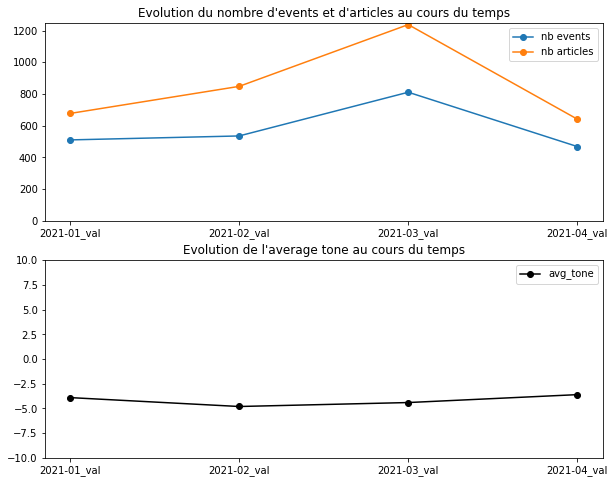

In [16]:
date_min = 20210101 # indiquer le 1er jour du premier mois à analyser - format YYYYMMDD
date_max = 20210501 # indiquer le 1er du mois suivant le dernier mois à analyser (ie si je veux analyser le mois d'avril, je mets 20210105)

pays_1 = "AG"
pays_2 = "FR"
n_limit = 5

global_start = datetime.datetime.now()

# generation manuelle de la date_range
date_min = pd.to_datetime(str(date_min))
date_max = pd.to_datetime(str(date_max))
date_range = pd.date_range(date_min,date_max,freq="MS")

# appel des fonctions
list_monthly_dfs = process_all_queries(date_range)
global_df = generate_global_df(list_monthly_dfs)
print(global_df)
display_evolution(global_df)

global_duration = datetime.datetime.now() - global_start
print(f"\n\nTOTAL TIME : {global_duration}\n\n")

In [5]:
global_df

,2021-01_id,2021-01_val,2021-02_id,2021-02_val,2021-03_id,2021-03_val,2021-04_id,2021-04_val
nb_events,nb_events,510.0,nb_events,535.0,nb_events,811.0,nb_events,468.0
nb_articles,nb_articles,677.0,nb_articles,848.0,nb_articles,1238.0,nb_articles,641.0
avg_tone,avg_tone,-3.9,avg_tone,-4.8,avg_tone,-4.4,avg_tone,-3.6
event_type_0,Appeal,45.0,Appeal,40.0,Use conventional military force,121.0,Host a visit,52.0
event_type_1,Use conventional military force,41.0,Use conventional military force,40.0,Host a visit,68.0,Make a visit,43.0
event_type_2,Make statement,40.0,Make statement,39.0,Physically assault,63.0,Make statement,30.0
event_type_3,Host a visit,31.0,Host a visit,35.0,Make a visit,62.0,Appeal,27.0
event_type_4,Make a visit,29.0,"Arrest, detain, or charge with legal action",30.0,"Arrest, detain, or charge with legal action",51.0,Use conventional military force,23.0
person_0,benjamin stora,181.0,abdelmalek hamzaoui,175.0,ali boumendjel,503.0,abdelaziz bouteflika,92.0
person_1,jacques chirac,112.0,francoise grandclaude,165.0,benjamin stora,322.0,benjamin stora,51.0
